https://towardsdatascience.com/step-by-step-r-cnn-implementation-from-scratch-in-python-e97101ccde55

and associated github directory https://github.com/1297rohit/RCNN

Note that RCNN.ipynb in github repo seems to have more stuff in it, but follow medium post for now.

*Background material*

https://www.analyticsvidhya.com/blog/2021/05/convolutional-neural-networks-cnn/

# My own laptop
https://stackoverflow.com/questions/57427233/module-cv2-cv2-has-no-attribute-ximgproc

- pip install opencv-contrib-python (if opencv-python is installed, remove it before this step)
- pip install keras
- tensorflow already installed (on my own laptop)

# Work MacBook Pro
Instructions for venv and pip install of required packages in notes 7 May 2021.

In [1]:
import tensorflow as tf
import keras

In [2]:
import os,cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

- Download the files: Images.zip and Airplanes_Annotations.zip
- Extract all images to Images subdirectory one level below this notebook
- Extract all labels to Airplanes_Annotations subdirectory one level below this notebook

In [3]:
path = "Images"
annot ="Airplanes_Annotations"

Test one image

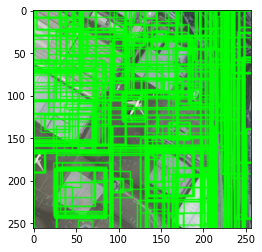

In [4]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
im = cv2.imread(os.path.join(path,"42850.jpg"))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
#     print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)

Planes3.jpg


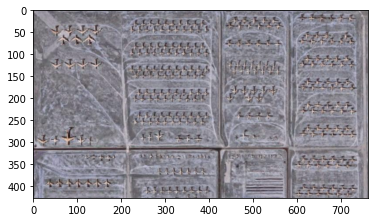

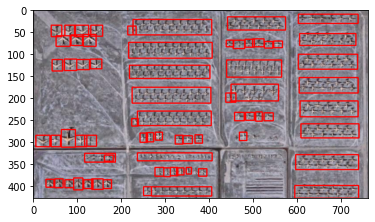

In [5]:
for e,i in enumerate(os.listdir(annot)):
    if e < 10:
        filename = i.split(".")[0]+".jpg"
        print(filename)
        img = cv2.imread(os.path.join(path,filename))
        #print(img)
        df = pd.read_csv(os.path.join(annot,i))
        plt.imshow(img)
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
        plt.figure()
        plt.imshow(img)
        break

Initialize selective search

In [6]:
cv2.setUseOptimized(True);
#ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation() # Done above to test a single image

Function to calculate IOU (Intersection Over Union) of the ground truth box from the box computed by selective search.

https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

In [7]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

## Preprocessing and dataset creation
Steps for pre-processing and creating the data-set to pass to the model. We can have 2 classes: these classes are that the proposed region can be a foreground (i.e. Airplane) or a background. So we will set the label of foreground (i.e. Airplane) as 1 and the label of background as 0. Steps are:
1. Loop over the image folder and set each image one by one as the base for selective search using code ss.setBaseImage(image)
2. Initialising fast selective search and getting proposed regions using using code ss.switchToSelectiveSearchFast() and ssresults = ss.process()
3. Iterating over all the first 2000 results passed by selective search and calculating IOU of the proposed region and annotated region using the get_iou() function created above.
4. Now as one image can many negative sample (i.e. background) and just some positive sample (i.e. airplane) so we need to make sure that we have good proportion of both positive and negative sample to train our model. Therefore we have set that we will collect maximum of 30 negative sample (i.e. background) and positive sample (i.e. airplane) from one image.

In [8]:
train_images=[]
train_labels=[]

**NOTE** Next cell takes a good 15 min to run on my Lenovo laptop, 4 min on work MacBook Pro

In [9]:
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

1 airplane_489.jpg
2 airplane_304.jpg
3 airplane_462.jpg
4 airplane_476.jpg
5 airplane_310.jpg
6 airplane_338.jpg
inside
7 airplane_660.jpg
8 airplane_106.jpg
9 airplane_112.jpg
inside
10 airplane_674.jpg
11 airplane_648.jpg
12 airplane_099.jpg
13 airplane_072.jpg
14 airplane_066.jpg
15 airplane_700.jpg
17 airplane_270.jpg
18 airplane_516.jpg
19 airplane_502.jpg
20 airplane_264.jpg
inside
21 airplane_258.jpg
22 airplane_259.jpg
23 airplane_503.jpg
24 airplane_265.jpg
25 airplane_271.jpg
26 airplane_517.jpg
28 airplane_067.jpg
29 airplane_073.jpg
30 airplane_098.jpg
31 airplane_649.jpg
32 airplane_113.jpg
33 airplane_675.jpg
34 airplane_661.jpg
35 airplane_107.jpg
36 airplane_339.jpg
37 airplane_477.jpg
38 airplane_311.jpg
39 airplane_305.jpg
inside
40 airplane_463.jpg
41 airplane_488.jpg
43 airplane_313.jpg
44 airplane_475.jpg
45 airplane_461.jpg
46 airplane_307.jpg
47 airplane_449.jpg
48 airplane_688.jpg
49 airplane_677.jpg
50 airplane_111.jpg
51 airplane_105.jpg
52 airplane_663.jpg
5

407 airplane_224.jpg
408 airplane_595.jpg
409 airplane_581.jpg
411 airplane_032.jpg
412 airplane_026.jpg
413 airplane_608.jpg
414 airplane_620.jpg
415 airplane_146.jpg
416 airplane_152.jpg
417 airplane_634.jpg
418 airplane_185.jpg
419 airplane_191.jpg
420 airplane_378.jpg
421 airplane_344.jpg
422 airplane_422.jpg
423 airplane_436.jpg
424 airplane_350.jpg
425 airplane_387.jpg
426 airplane_393.jpg
427 airplane_397.jpg
428 airplane_383.jpg
inside
429 airplane_368.jpg
430 airplane_354.jpg
431 airplane_432.jpg
432 airplane_426.jpg
433 airplane_340.jpg
434 airplane_195.jpg
435 airplane_181.jpg
436 airplane_618.jpg
437 airplane_630.jpg
438 airplane_156.jpg
439 airplane_142.jpg
440 airplane_624.jpg
inside
442 airplane_022.jpg
443 airplane_036.jpg
444 airplane_585.jpg
445 airplane_591.jpg
446 airplane_208.jpg
447 airplane_220.jpg
448 airplane_546.jpg
449 airplane_552.jpg
450 airplane_234.jpg
451 airplane_553.jpg
inside
452 airplane_235.jpg
453 airplane_221.jpg
454 airplane_547.jpg
455 airplane_

Training data is now ready. List train_images=[] will contain all the images and train_labels=[] will contain all the labels marking airplane images as 1 and non airplane images (i.e. background images) as 0.

In [10]:
# check for 0,1
print(train_labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## Train a model
After completing the process of creating the dataset we will convert the array to numpy array so that we can traverse it easily and pass the datatset to the model in an efficient way.

In [11]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

Now we will do transfer learning on the imagenet weight. We will import VGG16 model and also put the imagenet weight in the model. To learn more about transfer learning you can refer to the article on link below.

https://medium.com/@1297rohit/transfer-learning-from-scratch-using-keras-339834b153b9

https://keras.io/api/applications/ For more on keras VGG16 model

In [12]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
vggmodel = VGG16(weights='imagenet', include_top=True)

- we are freezing the first 15 layers of the model. 
- After that we are taking out the second last layer of the model and then adding a 2 unit softmax dense layer as we have just 2 classes to predict i.e. foreground or background. 
- After that we are compiling the model using Adam optimizer with learning rate of 0.001. We are using categorical_crossentropy as loss since the output of the model is categorical. 
- Finally the summary of the model will is printed using model_final.summary().

In [13]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False
X = vggmodel.layers[-2].output
predictions = Dense(2, activation="softmax")(X)

Error with the keyword input below: https://github.com/keras-team/keras/issues/13743

In [14]:
#model_final = Model(input = vggmodel.input, output = predictions) # error
model_final = Model(vggmodel.input, predictions) # no error using positional keywords
opt = Adam(learning_rate=0.0001) #lr depcicated, use learning_rate instead
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])
model_final.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Encode the dataset
After creating the model now we need to split the dataset into train and test set. Before that we need to one-hot encode the label. For that we are using MyLabelBinarizer() and encoding the dataset. Then we are splitting the dataset using train_test_split from sklearn. We are keeping 10% of the dataset as test set and 90% as training set.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [16]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

Use Keras ImageDataGenerator to pass the dataset to the model. We will do some augmentation on the dataset like horizontal flip, vertical flip and rotation to increase the dataset.

In [17]:
# Check dtype of train/test data
print(X_train.dtype)
print(X_test.dtype)
print(y_train.dtype)
print(y_test.dtype)

uint8
uint8
int64
int64


***
Next cell gives a **MemoryError: Unable to allocate 15.3 GiB for an array with shape (27206, 224, 224, 3) and data type float32**
Can't go any further with this on my own laptop (8G RAM) but runs on MacBook Pro (16G).

Possible solution:
https://stackoverflow.com/questions/57507832/unable-to-allocate-array-with-shape-and-data-type

https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/

keras ImageDataGenerator class: https://keras.io/api/preprocessing/image/

Possibly the batch_size in flow? No.

In [19]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)# *
#traindata = trdata.flow(x=X_train, y=y_train, batch_size=4)# batch_size <32 doesn't help
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

Now we start the training of the model using fit_generator. For 1000 epochs it's going to take hours. It's set up to stop early and so avoid over-fitting the test data. Alternative is to runfor 100 epochs, check loss, run cell again if need be (model continues training from where it left off). Model saved as ieeercnn_vgg16_1.h5 so could be loaded/served and just fed images.

In [20]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 1000, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

/opt/anaconda3/envs/mlearn/lib/python3.9/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/1000
10/10 [==============================] - 56s 4s/step - loss: 1.8290 - accuracy: 0.6263 - val_loss: 0.1410 - val_accuracy: 0.9375

Epoch 00001: val_loss improved from inf to 0.14100, saving model to ieeercnn_vgg16_1.h5
Epoch 2/1000
10/10 [==============================] - 41s 4s/step - loss: 0.3244 - accuracy: 0.8646 - val_loss: 0.4045 - val_accuracy: 0.8438

Epoch 00002: val_loss did not improve from 0.14100
Epoch 3/1000
10/10 [==============================] - 42s 4s/step - loss: 0.2316 - accuracy: 0.9086 - val_loss: 0.2388 - val_accuracy: 0.9531

Epoch 00003: val_loss did not improve from 0.14100
Epoch 4/1000
10/10 [==============================] - 43s 4s/step - loss: 0.2435 - accuracy: 0.9220 - val_loss: 0.2464 - val_accuracy: 0.9375

Epoch 00004: val_loss did not improve from 0.14100
Epoch 5/1000
10/10 [==============================] - 42s 4s/step - loss: 0.2090 - accuracy: 0.9139 - val_loss: 0.1028 - val_accuracy: 0.9531

Epoch 00005: val_loss improved from 0.14100 

10/10 [==============================] - 41s 4s/step - loss: 0.2540 - accuracy: 0.9230 - val_loss: 0.0605 - val_accuracy: 0.9844

Epoch 00042: val_loss improved from 0.09161 to 0.06051, saving model to ieeercnn_vgg16_1.h5
Epoch 43/1000
10/10 [==============================] - 41s 4s/step - loss: 0.1779 - accuracy: 0.9230 - val_loss: 0.1633 - val_accuracy: 0.9219

Epoch 00043: val_loss did not improve from 0.06051
Epoch 44/1000
10/10 [==============================] - 41s 4s/step - loss: 0.1613 - accuracy: 0.9558 - val_loss: 0.3252 - val_accuracy: 0.8906

Epoch 00044: val_loss did not improve from 0.06051
Epoch 45/1000
10/10 [==============================] - 41s 4s/step - loss: 0.2520 - accuracy: 0.8915 - val_loss: 0.2514 - val_accuracy: 0.8750

Epoch 00045: val_loss did not improve from 0.06051
Epoch 46/1000
10/10 [==============================] - 40s 4s/step - loss: 0.2279 - accuracy: 0.9196 - val_loss: 0.0905 - val_accuracy: 0.9844

Epoch 00046: val_loss did not improve from 0.0605


Epoch 00083: val_loss did not improve from 0.05244
Epoch 84/1000
10/10 [==============================] - 38s 4s/step - loss: 0.1617 - accuracy: 0.9528 - val_loss: 0.1025 - val_accuracy: 0.9688

Epoch 00084: val_loss did not improve from 0.05244
Epoch 85/1000
10/10 [==============================] - 38s 4s/step - loss: 0.1446 - accuracy: 0.9410 - val_loss: 0.1452 - val_accuracy: 0.9531

Epoch 00085: val_loss did not improve from 0.05244
Epoch 86/1000
10/10 [==============================] - 37s 4s/step - loss: 0.1925 - accuracy: 0.9180 - val_loss: 0.1917 - val_accuracy: 0.9219

Epoch 00086: val_loss did not improve from 0.05244
Epoch 87/1000
10/10 [==============================] - 37s 4s/step - loss: 0.1123 - accuracy: 0.9565 - val_loss: 0.1489 - val_accuracy: 0.9375

Epoch 00087: val_loss did not improve from 0.05244
Epoch 88/1000
10/10 [==============================] - 37s 4s/step - loss: 0.1179 - accuracy: 0.9575 - val_loss: 0.1003 - val_accuracy: 0.9375

Epoch 00088: val_loss di

10/10 [==============================] - 37s 4s/step - loss: 0.1573 - accuracy: 0.9516 - val_loss: 0.2406 - val_accuracy: 0.9375

Epoch 00125: val_loss did not improve from 0.04979
Epoch 126/1000
10/10 [==============================] - 37s 4s/step - loss: 0.1452 - accuracy: 0.9396 - val_loss: 0.0366 - val_accuracy: 0.9844

Epoch 00126: val_loss improved from 0.04979 to 0.03660, saving model to ieeercnn_vgg16_1.h5
Epoch 127/1000
10/10 [==============================] - 38s 4s/step - loss: 0.1994 - accuracy: 0.9267 - val_loss: 0.2005 - val_accuracy: 0.9219

Epoch 00127: val_loss did not improve from 0.03660
Epoch 128/1000
10/10 [==============================] - 38s 4s/step - loss: 0.1208 - accuracy: 0.9657 - val_loss: 0.2000 - val_accuracy: 0.9375

Epoch 00128: val_loss did not improve from 0.03660
Epoch 129/1000
10/10 [==============================] - 38s 4s/step - loss: 0.1031 - accuracy: 0.9604 - val_loss: 0.1270 - val_accuracy: 0.9688

Epoch 00129: val_loss did not improve from 0.

10/10 [==============================] - 38s 4s/step - loss: 0.1091 - accuracy: 0.9594 - val_loss: 0.1078 - val_accuracy: 0.9688

Epoch 00166: val_loss did not improve from 0.02531
Epoch 167/1000
10/10 [==============================] - 38s 4s/step - loss: 0.1335 - accuracy: 0.9703 - val_loss: 0.0625 - val_accuracy: 0.9688

Epoch 00167: val_loss did not improve from 0.02531
Epoch 168/1000
10/10 [==============================] - 38s 4s/step - loss: 0.0757 - accuracy: 0.9808 - val_loss: 0.1558 - val_accuracy: 0.9219

Epoch 00168: val_loss did not improve from 0.02531
Epoch 169/1000
10/10 [==============================] - 38s 4s/step - loss: 0.0942 - accuracy: 0.9657 - val_loss: 0.0413 - val_accuracy: 0.9844

Epoch 00169: val_loss did not improve from 0.02531
Epoch 170/1000
10/10 [==============================] - 38s 4s/step - loss: 0.1281 - accuracy: 0.9658 - val_loss: 0.1716 - val_accuracy: 0.9688

Epoch 00170: val_loss did not improve from 0.02531
Epoch 171/1000
10/10 [=============

10/10 [==============================] - 38s 4s/step - loss: 0.1979 - accuracy: 0.9263 - val_loss: 0.0877 - val_accuracy: 0.9844

Epoch 00208: val_loss did not improve from 0.02531
Epoch 209/1000
10/10 [==============================] - 38s 4s/step - loss: 0.1143 - accuracy: 0.9670 - val_loss: 0.1113 - val_accuracy: 0.9844

Epoch 00209: val_loss did not improve from 0.02531
Epoch 210/1000
10/10 [==============================] - 37s 4s/step - loss: 0.0950 - accuracy: 0.9722 - val_loss: 0.1786 - val_accuracy: 0.9531

Epoch 00210: val_loss did not improve from 0.02531
Epoch 211/1000
10/10 [==============================] - 37s 4s/step - loss: 0.2669 - accuracy: 0.9112 - val_loss: 0.1146 - val_accuracy: 0.9531

Epoch 00211: val_loss did not improve from 0.02531
Epoch 212/1000
10/10 [==============================] - 37s 4s/step - loss: 0.1001 - accuracy: 0.9775 - val_loss: 0.1356 - val_accuracy: 0.9531

Epoch 00212: val_loss did not improve from 0.02531
Epoch 213/1000
10/10 [=============

10/10 [==============================] - 38s 4s/step - loss: 0.1092 - accuracy: 0.9722 - val_loss: 0.2319 - val_accuracy: 0.9219

Epoch 00250: val_loss did not improve from 0.02531
Epoch 251/1000
10/10 [==============================] - 38s 4s/step - loss: 0.0900 - accuracy: 0.9579 - val_loss: 0.1711 - val_accuracy: 0.9531

Epoch 00251: val_loss did not improve from 0.02531
Epoch 252/1000
10/10 [==============================] - 37s 4s/step - loss: 0.1491 - accuracy: 0.9473 - val_loss: 0.1372 - val_accuracy: 0.9219

Epoch 00252: val_loss did not improve from 0.02531
Epoch 253/1000
10/10 [==============================] - 38s 4s/step - loss: 0.0903 - accuracy: 0.9683 - val_loss: 0.2190 - val_accuracy: 0.9219

Epoch 00253: val_loss did not improve from 0.02531
Epoch 254/1000
10/10 [==============================] - 38s 4s/step - loss: 0.1169 - accuracy: 0.9624 - val_loss: 0.1054 - val_accuracy: 0.9375

Epoch 00254: val_loss did not improve from 0.02531
Epoch 255/1000
10/10 [=============

Once we have created the model. We need to do prediction on that model. For that we need to follow these steps:
- pass the image from selective search.
- pass all the result of the selective search to the model as input using model_final.predict(img).
- If the output of the model says the region to be a foreground image (i.e. airplane image), and if the confidence is above the defined threshold, then create bounding box on the original image on the coordinate of the proposed region.

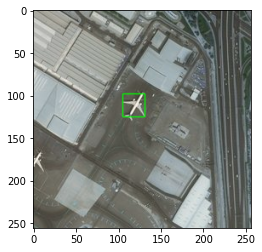

In [21]:
z=0
for e,i in enumerate(os.listdir(path)):
    if i.startswith("4"):
        z += 1
        img = cv2.imread(os.path.join(path,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model_final.predict(img)
                if out[0][0] > 0.70:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        plt.figure()
        plt.imshow(imout)
        break